# QuTiP Example: Quantum System Subject to to Coherent Feedback with Discrete Time-Delay

[Arne L. Grimsmo](http://arnegrimsmo.weebly.com/) <br>
Université de Sherbrooke <br>
[arne.grimsmo@gmail.com](email:arne.grimsmo@gmail.com)
$\newcommand{\ket}[1]{\left|#1\right\rangle}$
$\newcommand{\bra}[1]{\left\langle#1\right|}$

## Introduction

This notebook shows how to use the `memorycascade` module, one of the modules for non-Markovian systems in qutip. This module is an implementation of the method introduced in [Phys. Rev. Lett 115, 060402 (2015)](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.060402) ([arXiv link](http://arxiv.org/abs/1502.06959)) to integrate the dynamics of open quantum systems coupled to a coherent feedback loop with a time-delay.

At the end of the notebook we also show how the `memorycascade` module can be used in conjunction with the `transfertensormethod` module.

In this notebook we consider a paradigmatic quantum optics example of a system subject to coherent feedback, namely a two-level atom in front of a mirror. The setup is illustrated in the figure below:

![Atom in front of a mirror](images/atommirror.png)

An atom is placed a distance $l$ in front of a mirror. The incomming field on the left side, $b_{\text{in}}(t)$, we take to be a vacuum field. The field on the right side of the atom, i.e., the field between the atom and the mirror, creates a coherent feedback loop with time-delay $\tau = l/c$, where $c$ is the speed of light. The atom couples to the input field via a system operator $L_1$, and to the returning feedback field via a system operator $L_2$. We assume that an arbitrary phase shift, $\phi$, can be applied to the feedback field (e.g., there could be a phase-shifter placed in the loop [not shown]). In addition, there can be Markovian non-radiative decay, described by a rate $\gamma_{\rm nr}$. The red arrow denotes a classical drive field, assumed to couple to the atom via a side-channel.

## Preamble

### Imports

In [1]:
import numpy as np
import scipy as sp

import qutip as qt
from qutip.ipynbtools import version_table

import qutip.nonmarkov.memorycascade as mc

%matplotlib inline
import matplotlib.pyplot as plt

/Users/arnelg/anaconda/envs/py35/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Problem setup

In [2]:
gamma = 1.0 # coupling strength to feedback reservoir
gamma_nr = 0.2*gamma # non-radiative decay
eps = 1.0*np.pi*gamma # classical drive strength, eps/2 = Rabi frequency
delta = 0. # detuning from the drive frequency

tau = np.pi/(eps) # time-delay, chosen to exactly match the Rabi period due to the drive
print('tau=', tau)
phi = 1.0*np.pi # phase shift in feedback loop

# Hamiltonian and jump operators
H_S = delta*qt.sigmap()*qt.sigmam() + 1j*eps*(qt.sigmam()-qt.sigmap())
# coupling at first port of feedback loop (into the loop)
L1 = sp.sqrt(gamma)*qt.sigmam()
# coupling at second port of feedback loop (out of the loop)
L2 = sp.exp(1j*phi)*L1

# Markovian decay channels
c_ops_markov = [sp.sqrt(gamma_nr)*qt.sigmam()]

# initial state
rho0 = qt.ket2dm(qt.basis(2,0)) # atom start in the excited state

# integration times
times = np.arange(0.0, 3.0*tau, 0.01*tau)

tau= 1.0


## Memory cascade simulation

The memory cascade method works by mapping the non-Markovian feedback problem onto a problem of $k$ identical cascaded quantum systems, where $(k-1)\tau < t < k\tau$ for a time $t$.

To use the memory cascade method in qutip, first create a `MemoryCascade` object. The syntax is

````
sim = MemoryCascade(H_S, L1, L2, S_matrix=None, c_ops_markov=None, integrator='propagator', paralell=False, options=None)
````

where

`H_S` is a system Hamiltonian (or a Liouvillian).

`L1` and `L2` are either single system operators, or lists of system operators. `L1` couples the system into the feedback loop, and `L2` couples out of the loop. If `L1` and `L2` are lists, the optional argument `S_matrix` can be used to specify an $S$-matrix that determines which operator in `L1` couples to which operator in `L2` (note that `L1` and `L2` must have the same number of elements). By default `S_matrix` will be set to an $n \times n$ identity matrix, where n is the number of elements in `L1`/`L2`. Having multiple coupling operators into and out of the feedback loop can for example be used to describe composite systems emitting at multiple frequencies. The $S$-matrix can then be used to include, e.g., beam splitters mixing the different signals in the feedback loop.

`c_ops_markov` is an optional list of additional Lindblad operators describing conventional Markovian noise channels, e.g., non-radiative decay.

`integrator` is a string which can be either 'propagator' or 'mesolve', referring to which method will be used to integrate the dynamics. "propagator" tends to be faster for larger systems (longer times)

`parallel` if set to True means the time-integration is parallelized. This is only implemented for `integrator='propagator'`

`options` an instance of the `qutip.Options` class for genereic solver options, used in internal calls to `qutip.propagator()`.

In [7]:
sim = mc.MemoryCascade(H_S, L1, L2, c_ops_markov=c_ops_markov, integrator='mesolve')

### Reduced atom dynamics

To compute the reduced density matrix of the atom at time $t$ with time-delay $\tau$, simply call the method `rhot` of the `MemoryCascade` object.

In [8]:
%time rho = [sim.rhot(rho0, t, tau) for t in times]

CPU times: user 28.3 s, sys: 284 ms, total: 28.5 s
Wall time: 29.5 s


Now lets plot the atomic inversion as a function of time:

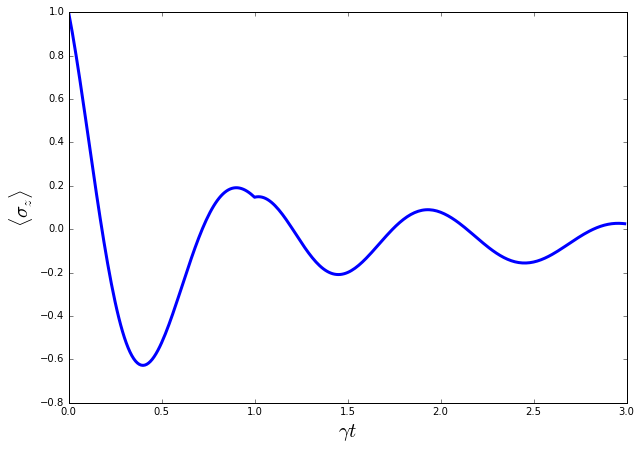

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(times, qt.expect(qt.sigmaz(), rho), linewidth=3.0)
ax.set_xlabel(r'$\gamma t$', fontsize=20)
ax.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=20)

### Output field dynamics

The `MemoryCascade` class also has a convenient method called `outfieldcorr` that allows you to compute any ouput field correlation function of the type

$$
\langle c_1(t_1) c_{2}(t_{2}) \dots c_n(t_n) \rangle
$$

where each $c_i(t_i)$ is one of $b_{\rm out}(t_i)$ or $b_{\rm out}^\dagger (t_i)$ (see the figure at the top). Below we use `outfieldcorr` to compute the photon number and the $g^{(2)}(0,t)$ correlation function of the output field.

The syntax of `outfieldcorr` is

````
outfieldcorr(rho0, blist, tlist, tau)
````

where

`rho0` is the atom's initial state

`blist` is a list of integers specifying the operators $c_i$, where an entry of `1` means $b_{\rm out}$ and an entry of `2` means $b_{\rm out}^\dagger$. So, for example `blist = [1, 2, 2, 1]` means that we want to compute $\langle b_{\rm out}(t_1) b_{\rm out}^\dagger(t_2) b_{\rm out}^\dagger(t_3) b_{\rm out}(t_4)\rangle$.

`tlist` is the corresponding list of times, $t_1, t_2, \dots, t_n$.

`tau` is as usual the time-delay.

#### Output field photon number

In [10]:
%time bdb = [sim.outfieldcorr(rho0, [2, 1], [t, t], tau) for t in times]

CPU times: user 27.5 s, sys: 343 ms, total: 27.8 s
Wall time: 28.7 s


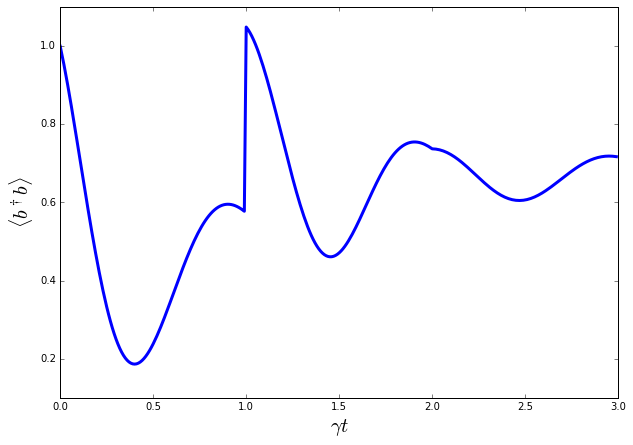

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(times, bdb, linewidth=3.0)
ax.set_xlabel(r'$\gamma t$', fontsize=20)
ax.set_ylabel(r'$\langle b^\dagger b \rangle$', fontsize=20)

#### Output field second order correlation function

In [12]:
%time g2 = [sim.outfieldcorr(rho0, [2, 1, 2, 1], [times[i], times[i], 0., 0.], tau)/(bdb[0]*bdb[i]) for i in range(len(times))]

CPU times: user 24.1 s, sys: 91.3 ms, total: 24.2 s
Wall time: 24.3 s


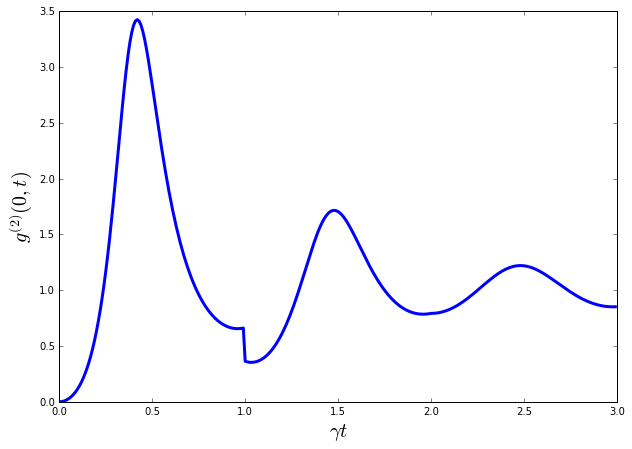

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(times, g2, linewidth=3.0)
ax.set_xlabel(r'$\gamma t$', fontsize=20)
ax.set_ylabel(r'$g^{(2)}(0,t)$', fontsize=20)

## Extrapolate to large times using the Transfer Tensor Method

Since the memory cascade method maps the non-Markovian problem onto a chain of $k$ cascaded systems, where $(k-1)\tau < t < k\tau$, it is intractable for large times due to the exponential growth of the Hilbert space with $k$.

A useful approach is therefore to use the memory cascade method in conjunction with the Transfer Tensor Method (TTM), implemented in qutip in the `transfertensormethod` module in the `nonmarkov` subpackage.

The usage of the `transfertensormethod` module is discussed in more detail in the [example-transfer-tensor-method](example-transfer-tensor-method.ipynb) notebook.

In [14]:
import qutip.nonmarkov.transfertensor as ttm

### Construct a list of exact timepropagators to learn from

The `MemoryCascade` class also has a method `propagator` that returns the time-propagator for the atom at a time $t$, i.e., the superoperator $\mathcal{E}(t)$ such that

$$
\rho(t) = \mathcal{E}(t)\rho(0),
$$

where $\rho(t)$ is the state of the atom. We compute a list of exact propagators $\mathcal{E}(t_k)$ for a set of "learning times" $t_k$, which we then use as input to the TTM.

In [15]:
learningtimes = np.arange(0, 3*tau, 0.1*tau) # short times to learn from
%time learningmaps = [sim.propagator(t, tau) for t in learningtimes] # generate exact dynamical maps to learn from

CPU times: user 2.77 s, sys: 21.9 ms, total: 2.79 s
Wall time: 2.83 s


### Compute approximate solution for long times using the TTM

In [16]:
longtimes = np.arange(0, 10*tau, 0.1*tau) # long times for extrapolation
%time ttmsol = ttm.ttmsolve(learningmaps, rho0, longtimes) # extrapolate using TTM

CPU times: user 2.56 s, sys: 42.1 ms, total: 2.6 s
Wall time: 2.66 s


### Plot and compare

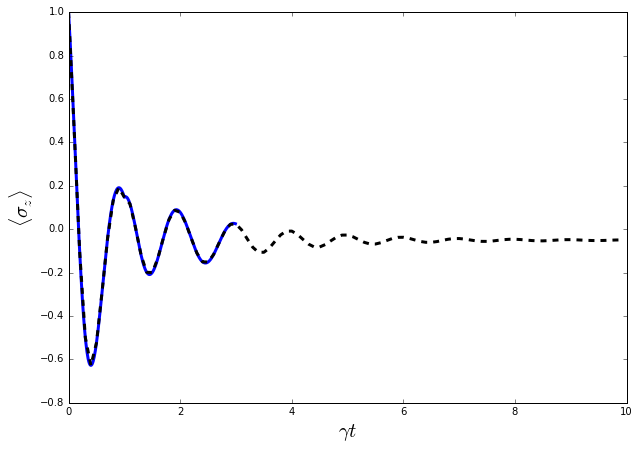

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(times, qt.expect(qt.sigmaz(), rho), linewidth=3.0)
ax.plot(longtimes, qt.expect(qt.sigmaz(), ttmsol.states), '--k', linewidth=3.0)
ax.set_xlabel(r'$\gamma t$', fontsize=20)
ax.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=20)

## Discussion

The above example shows how the memory cascade method can work well in conjunction with the TTM. The list of learning times necessary to get good result with the TTM will wary from problem to problem and from parameter set to parameter set. There is also no guarantee for the result being correct, but one can check convergence with increasing learning times.

In [18]:
version_table()

Software,Version
QuTiP,3.2.0.dev-05e6c1c
Numpy,1.10.4
SciPy,0.17.0
matplotlib,1.5.1
Cython,0.23.4
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,4.1.2
Python,"3.5.1 |Anaconda custom (x86_64)| (default, Dec 7 2015, 11:24:55) [GCC 4.2.1 (Apple Inc. build 5577)]"
OS,posix [darwin]
